In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("cleaned_ebay_deals.csv")
print(df.head())


             timestamp                                              title  \
0  2025-03-19 06:28:22  Klipsch R-120SWi 12" High-Performance Wireless...   
1  2025-03-19 06:28:22  Apple iPhone 14 Pro Max 128GB Network Unlocked...   
2  2025-03-19 06:28:22  Apple iPhone 14 Pro Max 256GB Unlocked Very Go...   
3  2025-03-19 06:28:22  Apple iPhone 14 Pro A2650 128GB Network Unlock...   
4  2025-03-19 06:28:22  Apple iPhone 14 128GB Network Unlocked Very Go...   

    price  original_price       shipping  \
0  159.99          179.99  Free shipping   
1  499.99         1099.00  Free shipping   
2  549.99         1199.00  Free shipping   
3  414.99          899.00  Free shipping   
4  305.99          749.00  Free shipping   

                                                 url  discount_percentage  
0  https://www.ebay.com/itm/365374754988?_trkparm...                11.11  
1  https://www.ebay.com/itm/365374754988?_trkparm...                54.51  
2  https://www.ebay.com/itm/365374754988?_tr

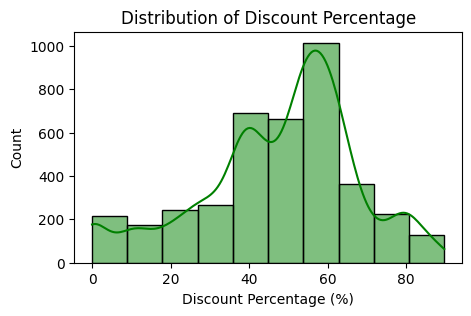

In [2]:
#data preparation

df = df.dropna(subset=["price", "original_price", 'shipping', 'discount_percentage'])

# Histogram of discount percentage
plt.figure(figsize=(5, 3))
sns.histplot(df['discount_percentage'], bins=10, kde=True, color='green')
plt.xlabel("Discount Percentage (%)")
plt.title("Distribution of Discount Percentage")
plt.show()


In [3]:
#Binning and balancing the dataset

# Create a new discount_bin
def categorize_discount(val):
    if val <= 10:
        return 'Low'
    elif val <= 30:
        return 'Medium'
    else:
        return 'High'

df['discount_bin'] = df['discount_percentage'].apply(categorize_discount)

# Count per bin
print(df['discount_bin'].value_counts())

# Undersample to balance
min = df['discount_bin'].value_counts().min()
balanced_df = df.groupby('discount_bin').sample(n=min, random_state=42)
print(balanced_df['discount_bin'].value_counts())

# Drop bin column
balanced_df = balanced_df.drop(columns=['discount_bin'])


discount_bin
High      3226
Medium     488
Low        261
Name: count, dtype: int64
discount_bin
High      261
Low       261
Medium    261
Name: count, dtype: int64


In [4]:
#turn shipping column into numeric
print(balanced_df['shipping'].unique())

balanced_df['shipping'] = balanced_df['shipping'].replace({
    'Free shipping': 1,
    'Shipping info unavailable': 0
})
print(balanced_df['shipping'].unique())


['Shipping info unavailable' 'Free shipping']
[0 1]


C:\Users\USER\AppData\Local\Temp\ipykernel_26964\867444028.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  balanced_df['shipping'] = balanced_df['shipping'].replace({


In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from prettytable import PrettyTable


X = balanced_df[['price', 'original_price', 'shipping']]
y = balanced_df['discount_percentage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")



# Create a PrettyTable
table = PrettyTable()
table.field_names = ["Metric", "Value"]
table.add_row(["MAE", round(mae, 2)])
table.add_row(["MSE", round(mse, 2)])
table.add_row(["RMSE", round(rmse, 2)])
table.add_row(["R² Score", round(r2, 2)])


# Print the table
print(table)


MAE: 10.07
MSE: 161.69
RMSE: 12.72
R² Score: 0.67
+----------+--------+
|  Metric  | Value  |
+----------+--------+
|   MAE    | 10.07  |
|   MSE    | 161.69 |
|   RMSE   | 12.72  |
| R² Score |  0.67  |
+----------+--------+


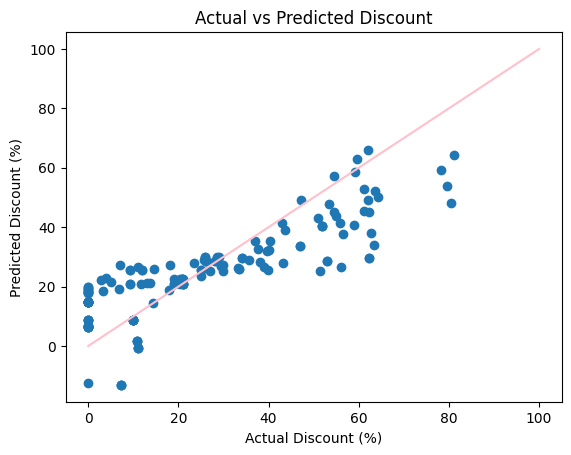

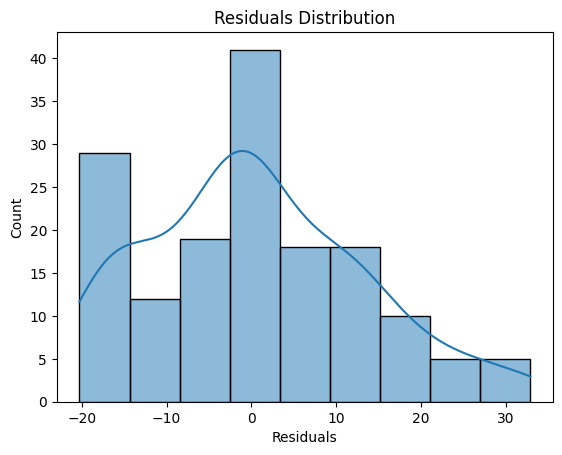

In [6]:
# Scatter plot actual vs predicted
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Discount (%)")
plt.ylabel("Predicted Discount (%)")
plt.title("Actual vs Predicted Discount")
plt.plot([0, 100], [0, 100], color='pink')
plt.show()

# Residual plot
residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.show()


In [7]:
from prettytable import PrettyTable

# Simulate 20 random products with missing discount info
incomplete_df = df[['price', 'original_price', 'shipping', 'title']].sample(n=20, random_state=42)

# Clean and encode 'shipping' values
incomplete_df['shipping'] = incomplete_df['shipping'].astype(str).str.strip().str.lower()
incomplete_df['shipping'] = incomplete_df['shipping'].replace({
    'free shipping': 1,
    'shipping info unavailable': 0
})

# Predict discount percentage
incomplete_df['Predicted Discount (%)'] = model.predict(incomplete_df[['price', 'original_price', 'shipping']])


# Create a PrettyTable
table = PrettyTable()
table.field_names = ["Title", "Price", "Original Price", "Shipping", "Predicted Discount"]
for _, row in incomplete_df.iterrows():
    table.add_row([row['title'], row['price'], row['original_price'], row['shipping'], round(row['Predicted Discount (%)'], 2)])

# Print the table
print(table)
# Display results
print(incomplete_df[['title', 'price', 'original_price', 'shipping', 'Predicted Discount (%)']])


+----------------------------------------------------------------------------------+--------+----------------+----------+--------------------+
|                                      Title                                       | Price  | Original Price | Shipping | Predicted Discount |
+----------------------------------------------------------------------------------+--------+----------------+----------+--------------------+
|                    Apple iPhone 14 128GB Unlocked - Excellent                    | 340.95 |     799.0      |    0     |       37.98        |
| HP ENVY Laptop Intel Core Ultra 7 155U RTX 3050 32GB RAM 1TB SSD 17.3" FHD W11H  | 769.99 |    1099.99     |    0     |       27.16        |
|            Apple iPhone 14 Pro Max 256GB Unlocked Very Good Condition            | 559.99 |     1199.0     |    0     |       42.81        |
|    Samsung Galaxy S21 5G SM-G991U 128GB 256GB Unlocked Very Good Refurbished     | 161.95 |    1199.99     |    1     |       69.46        |

C:\Users\USER\AppData\Local\Temp\ipykernel_26964\3429110550.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  incomplete_df['shipping'] = incomplete_df['shipping'].replace({
